<a href="https://colab.research.google.com/github/VitorMazziero/Processos-Fermentativos/blob/main/Modelagem%20-%20Batelada%20e%20Semicont%C3%ADnuo%20(Monod).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelagem biorreator operado em Batelada 

Ao criar o arquivo em excel adicionar os valores na planilha da seguinte forma e salvar o arquivo como: **dados_bat_monod.xlsx** para batelada e **dados_bat_alimentada_monod.xlsx** para batelada alimentada.

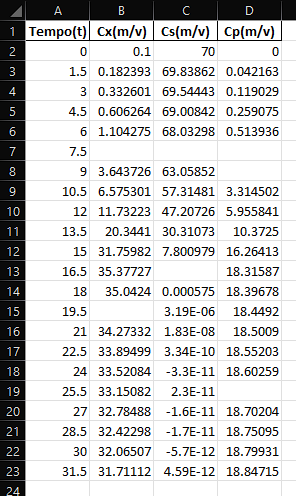

*Não deixar mais que duas células vazias em sequência para não atrapalhar o ajuste.

Como adicionar o arquivo com os dados experimentais no Colab:

1. No painel direito selecionar a pasta de arquivo

Picture1.png

2. Clicar no símbolo de upload

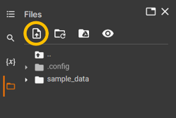

3. Selecionar o arquivo com os dados nomeado "dados_bat_monod.xlsx" e/ou "dados_bat_alimentada_monod.xlsx" e clicar em OK

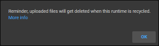

4. Executar o código para batelada e/ou batelada alimentada

5. Os parâmetros cinéticos ajustados serão apresentados embaixo do gráfico após em torno de 1min

### Batelada

In [ ]:
#importando as bibliotecas necessárias
import math
import numpy as np # biblioteca numpy
import pandas as pd #biblioteca de banco de dados
import matplotlib.pyplot as plt # biblioteca gráfica
from scipy.integrate import odeint #função de integração numérica
from scipy.optimize import differential_evolution #função de algoritmo genético

# função de equações diferenciais ordinárias
# Balanço de massa de células, substrato e produto considerando cinética de Monod
def growth (C, t, *args): 
    mimax = args[0]
    ks = args[1]
    alfa = args[2]
    Yxs = args[3]
    kd = args[4]
    beta = args[5]
    
    mi = (mimax*C[1])/(ks + C[1])
    dCxdt = (mi - kd) * C[0]
    dCsdt = -(1/Yxs)*mi *C[0]
    dCpdt = alfa*mi*C[0] + beta*C[0]
    return [dCxdt, dCsdt, dCpdt]

# Nome do arquivo Excel: dados_bat_monod.xlsx
dados = pd.read_excel("dados_bat_monod.xlsx")
dados_np = dados.values

# Adicionar os pontos faltantes como médias
i=0
while i < (np.shape(dados_np[:,0])[0]):
  j=1
  while j<=3:
    if math.isnan(dados_np[i,j]) is True:
      n=1
      if i+n>=np.shape(dados_np[:,0])[0] or i-n<0:
        if i-n<0:
          dados_np[i,j] = dados_np[i+n,j]
        else:  
          dados_np[i,j] = dados_np[i-n,j]
      else:
        if (math.isnan(dados_np[i+n,j]) or math.isnan(dados_np[i-n,j])) is True:
            dados_np[i,j] = (dados_np[i+n+1,j] + dados_np[i-n-1,j])/2
        else:
          dados_np[i,j] = (dados_np[i+n,j] + dados_np[i-n,j])/2
    j+=1
  i+=1

# Definição dos dados experimentais
exp_t = dados_np[:,0]
exp_C = dados_np[:,1:4]
  
# Condições iniciais Cx0, Cs0 e Cp0 - primeira linha da planilha do Excel
P_0 = (exp_C[0,0], exp_C[0,1], exp_C[0,2])

# Função objetiva, compara os pontos experimentais com o modelo
def func(parametros, *dados):

    exp_t,exp_C = dados
    p = tuple(parametros)
    sim_P = odeint(growth, P_0, exp_t, args = p)
    res = sim_P - exp_C
    res = res.flatten()
    res2 = sum(res**2)
    return res2

# Os limites para gerar os valores de mimax, ks, alfa, Yxs, kd e beta
bounds = [(0, 0.6), (0, 10), (0, 10), (0, 5), (0, 0.5), (0,10)]
# Os argumentos para o algoritmo genético
args = (exp_t,exp_C)
# A função de algoritmo genético
fitted_params= differential_evolution(func, bounds, args=args,  maxiter=500, popsize=25)

# Criando meu vetor tempo do modelo
n_steps = 200
t = np.linspace(0, exp_t[-1], n_steps)

# Imprime os valores
#print(fitted_params)
fitted_params=fitted_params.x        
fitted_params=tuple(fitted_params)
# Integrando com os valores dos parâmetros ajustados
Cotim = odeint(growth, P_0, t, args = (fitted_params))

#Função de impressão do gráfico
def imprimir (eixo_xexp, eixo_xm, Cx_exp, Cs_exp, Cp_exp, Cx_m, Cs_m, Cp_m):
    SMALL_SIZE = 14                        
    MEDIUM_SIZE = 20                       
    BIGGER_SIZE = 20
    plt.rc('font', size=SMALL_SIZE)          
    plt.rc('axes', titlesize=SMALL_SIZE)     
    plt.rc('axes', labelsize=MEDIUM_SIZE)    
    plt.rc('xtick', labelsize=SMALL_SIZE)    
    plt.rc('ytick', labelsize=SMALL_SIZE)    
    plt.rc('legend', fontsize=SMALL_SIZE)    
    plt.rc('figure', titlesize=BIGGER_SIZE)
    f = plt.figure()  
    ax = f.add_subplot(111)                                                 
    lns1 = ax.plot(eixo_xm ,Cx_m,'red',linewidth=3,label='Cx modelo')
    lns3 = ax.plot(eixo_xm ,Cp_m, linestyle="--", color='green',linewidth=3,label='Cp modelo')  
    lns2 = ax.plot(eixo_xexp ,Cx_exp,'or',markersize=6, label='Cx experimental')
    lns4 = ax.plot(eixo_xexp ,Cp_exp,'^g',markersize=6,label='Cp experimental')
    ax2 = ax.twinx()
    lns5 = ax2.plot(eixo_xm,Cs_m,linestyle=":", color='blue',linewidth=3,label='Cs modelo') 
    lns6 = ax2.plot(eixo_xexp,Cs_exp,'sb', markersize=6,label='Cs experimental')
    ax.set_xlabel('Tempo de cultivo (h)',weight='bold')               
    ax.set_ylabel('Cx e Cp (g/L)', weight='bold')
    ax2.set_ylabel('Cs (g/L)', weight='bold') 
    lns = lns1+lns2+lns3+lns4+lns5+lns6
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.17),ncol=3)                                                
    ax.grid(True)                     
    f.set_figheight(5)                                                 
    f.set_figwidth(7)                                                   
    f.patch.set_facecolor('white')                                   
    plt.style.use('default')    
    plt.savefig("Modelo batelada.png")
    plt.show()
#impressão do gráfico
imprimir(exp_t, t, exp_C[:,0], exp_C[:,1], exp_C[:,2], Cotim[:,0], Cotim[:,1], Cotim[:,2] )

#Calculo do R²
from sklearn.metrics import r2_score
Cotim_exp = odeint(growth, P_0, exp_t, args = (fitted_params))
Cxr_2 = r2_score(exp_C[:,0], Cotim_exp[:,0])
Csr_2 = r2_score(exp_C[:,1], Cotim_exp[:,1])
Cpr_2 = r2_score(exp_C[:,2], Cotim_exp[:,2])

print("\n" + "_______R²_______")
print("Modelo Cx: {:.4f}".format(Cxr_2))
print("Modelo Cs: {:.4f}".format(Csr_2))
print("Modelo Cp: {:.4f}".format(Cpr_2))

#imprimindo os valores dos parâmetros
param = np.asarray(fitted_params)
print("\n" + "____Resultado____")
print("μmax: {:.4f}".format(param[0]) +' 1/h')
print("ks: {:.4f}".format(param[1]) + ' g/L')
print("α: {:.4f}".format(param[2]))
print("Yxs: {:.4f}".format(param[3]))
print("kd: {:.4f}".format(param[4])+ ' 1/h')
print("β: {:.4f}".format(param[5]))

### Batelada alimentada

In [ ]:
#importando as bibliotecas necessárias
import math
import numpy as np # biblioteca numpy
import pandas as pd #biblioteca de banco de dados
import matplotlib.pyplot as plt # biblioteca gráfica
from scipy.integrate import odeint #função de integração numérica
from scipy.optimize import differential_evolution #função de algoritmo genético

# Parâmetros operacionais
V0 = 2.0
Qe = 0.25

# função de equações diferenciais ordinárias
# Balanço de massa de células, substrato e produto considerando cinética de Monod
def growth (C, t, *args): 
    Q = Qe
    V = V0+Q*t
    D = Q/V
    μmax = args[0]
    ks = args[1]
    α = args[2]
    Yxs = args[3]
    kd = args[4]
    β = args[5]
    Cse = args[6]
    
    μ = (μmax*C[1])/(ks + C[1])
    dCxdt = (μ-kd-D)*C[0] #Eq. (5)
    dCsdt = D*(Cse - C[1]) - μ*C[0]/Yxs #Eq. (10)
    dCpdt = D*(- C[2]) + α*μ*C[0]+β*C[0] #Eq. (16)
    return [dCxdt, dCsdt, dCpdt]

#Nome do arquivo Excel: dados_bat_monod.xlsx
dados = pd.read_excel("dados_bat_alimentada_monod.xlsx")
dados_np = dados.values

i=0
while i < (np.shape(dados_np[:,0])[0]):
  j=1
  while j<=3:
    if math.isnan(dados_np[i,j]) is True:
      n=1
      if i+n>=np.shape(dados_np[:,0])[0] or i-n<0:
        if i-n<0:
          dados_np[i,j] = dados_np[i+n,j]
        else:  
          dados_np[i,j] = dados_np[i-n,j]
      else:
        if (math.isnan(dados_np[i+n,j]) or math.isnan(dados_np[i-n,j])) is True:
            dados_np[i,j] = (dados_np[i+n+1,j] + dados_np[i-n-1,j])/2
        else:
          dados_np[i,j] = (dados_np[i+n,j] + dados_np[i-n,j])/2
    j+=1
  i+=1

exp_t = dados_np[:,0]
exp_C = dados_np[:,1:4]
  
# Condições iniciais Cx0, Cs0 e Cp0 - primeira linha da planilha do Excel
P_0 = (exp_C[0,0], exp_C[0,1], exp_C[0,2])

# Função objetiva, compara os pontos experimentais com o modelo
def func(parametros, *dados):

    exp_t,exp_C = dados
    p = tuple(parametros)
    sim_P = odeint(growth, P_0, exp_t, args = p)
    res = sim_P - exp_C
    res = res.flatten()
    res2 = sum(res**2)
    return res2

# Os limites para gerar os valores de mimax, ks, alfa, Yxs, kd e beta
bounds = [(0, 0.6), (0, 5), (0, 10), (0, 5), (0, 0.5), (0,10), (1,50)]
# Os argumentos para o algoritmo genético
args = (exp_t,exp_C)
# A função de algoritmo genético
fitted_params= differential_evolution(func, bounds, args=args,  maxiter=500, popsize=25)

# Criando meu vetor tempo do modelo
n_steps = 200
t = np.linspace(0, exp_t[-1], n_steps)

# Imprime os valores
#print(fitted_params)
fitted_params=fitted_params.x        
fitted_params=tuple(fitted_params)
# Integrando com os valores dos parâmetros ajustados
Cotim = odeint(growth, P_0, t, args = (fitted_params))

#Função de impressão do gráfico
def imprimir (eixo_xexp, eixo_xm, Cx_exp, Cs_exp, Cp_exp, Cx_m, Cs_m, Cp_m):
    SMALL_SIZE = 14                        
    MEDIUM_SIZE = 20                       
    BIGGER_SIZE = 20
    plt.rc('font', size=SMALL_SIZE)          
    plt.rc('axes', titlesize=SMALL_SIZE)     
    plt.rc('axes', labelsize=MEDIUM_SIZE)    
    plt.rc('xtick', labelsize=SMALL_SIZE)    
    plt.rc('ytick', labelsize=SMALL_SIZE)    
    plt.rc('legend', fontsize=SMALL_SIZE)    
    plt.rc('figure', titlesize=BIGGER_SIZE)
    f = plt.figure()  
    ax = f.add_subplot(111)                                                 
    lns1 = ax.plot(eixo_xm ,Cx_m,'red',linewidth=3,label='Cx modelo')
    lns3 = ax.plot(eixo_xm ,Cp_m, linestyle="--", color='green',linewidth=3,label='Cp modelo')  
    lns2 = ax.plot(eixo_xexp ,Cx_exp,'or',markersize=6, label='Cx experimental')
    lns4 = ax.plot(eixo_xexp ,Cp_exp,'^g',markersize=6,label='Cp experimental')
    ax2 = ax.twinx()
    lns5 = ax2.plot(eixo_xm,Cs_m,linestyle=":", color='blue',linewidth=3,label='Cs modelo') 
    lns6 = ax2.plot(eixo_xexp,Cs_exp,'sb', markersize=6,label='Cs experimental')
    ax.set_xlabel('Tempo de cultivo (h)',weight='bold')               
    ax.set_ylabel('Cx e Cp (g/L)', weight='bold')
    ax2.set_ylabel('Cs (g/L)', weight='bold') 
    lns = lns1+lns2+lns3+lns4+lns5+lns6
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.17),ncol=3)                                                
    ax.grid(True)                     
    f.set_figheight(5)                                                 
    f.set_figwidth(7)                                                   
    f.patch.set_facecolor('white')                                   
    plt.style.use('default')    
    plt.savefig("Modelo batelada.png")
    plt.show()
#impressão do gráfico
imprimir(exp_t, t, exp_C[:,0], exp_C[:,1], exp_C[:,2], Cotim[:,0], Cotim[:,1], Cotim[:,2] )

#Calculo do R2
from sklearn.metrics import r2_score
Cotim_exp = odeint(growth, P_0, exp_t, args = (fitted_params))
Cxr_2 = r2_score(exp_C[:,0], Cotim_exp[:,0])
Csr_2 = r2_score(exp_C[:,1], Cotim_exp[:,1])
Cpr_2 = r2_score(exp_C[:,2], Cotim_exp[:,2])

print("\n" + "_______R²_______")
print("Modelo Cx: {:.4f}".format(Cxr_2))
print("Modelo Cs: {:.4f}".format(Csr_2))
print("Modelo Cp: {:.4f}".format(Cpr_2))

#imprimindo os valores dos parâmetros
param = np.asarray(fitted_params)
print("\n" + "____Resultado____")
print("μmax: {:.4f}".format(param[0]) +' 1/h')
print("ks: {:.4f}".format(param[1]) + ' g/L')
print("α: {:.4f}".format(param[2]))
print("Yxs: {:.4f}".format(param[3]))
print("kd: {:.4f}".format(param[4])+ ' 1/h')
print("β: {:.4f}".format(param[5]))
print("Cse: {:.4f}".format(param[6]) + ' g/L')